In [194]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import sys

In [2]:
# custom parser because we can't read the last column into one cell (34359453)
# returns data frame with every change record
def parse(fname, NROWS=10000, NSKIP=1):
    NAMES=['index', 'type', 'time', 'date', 'flag', 'msg']
    records = []
    with open(fname, 'r') as f:
        i = 0
        for line in f:
            i += 1
            if i < NSKIP + 1: continue
            if i > NROWS + 1: break
        
            r = []; msg = ""
            for word in line.split(' '):
                if len(r) < len(NAMES) - 1 :
                    r.append(word)        # structured change log line
                else:
                    if word != '\n':
                        msg += word + ' ' # message isn't delimited
            r.append(msg)
            records.append(r)
    print "done w/ "  + fname
    return pd.DataFrame(records, columns=NAMES)
#df = parse("/root/l1-mar29-changelog-anon.log", NROWS=1000000)
df0 = parse("/root/day0", NROWS=36884)
df1 = parse("/root/day1", NROWS=1000000) #13249412)
df2 = parse("/root/day2", NROWS=1000000) #21073163)

done w/ /root/day0
done w/ /root/day1
done w/ /root/day2


In [3]:
def assign_unique_keys(keys):
    accesses = []; nkeys = 0
    for key in keys:
        try:
            keyid = keyids[key]
        except:
            keyids[key] = nkeys
            keyid = nkeys
            nkeys += 1
        accesses.append(keyid)
    return accesses

def to_seconds(ts):
    hours, minutes, seconds = ts.split(':')
    return float(seconds) + 60*float(minutes) + 60*60*float(hours)  

def get_ops(df, op):
    ops = df[df['type'] == op]
    time = ops['time'].apply(lambda x: to_seconds(x)).as_matrix()
    keys = ops['msg'].apply(lambda x: x.split(' ')[0].split('=')[1][:-1][1:])
    if len(time) == 0:
        return [], []
    return time - time[0], assign_unique_keys(keys)

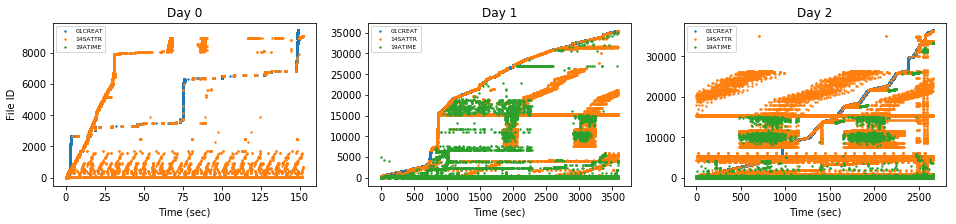

In [4]:
def plot_days(ops):
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 3))
    dfs = [df0, df1, df2]
    for i in range(0, len(dfs)):
        for op in ops:
            time, keys = get_ops(dfs[i], op)
            ax[i].scatter(time, keys, s=2, label=op)
        ax[i].set_xlabel("Time (sec)")
        #ax[i].set_ylim(0, 35000)    
        ax[i].set_title("Day " + str(i))
        ax[i].legend(loc='upper left', fontsize=6)
    ax[0].set_ylabel("File ID")    

keyids = {}; plot_days(['01CREAT', '14SATTR', '19ATIME'])

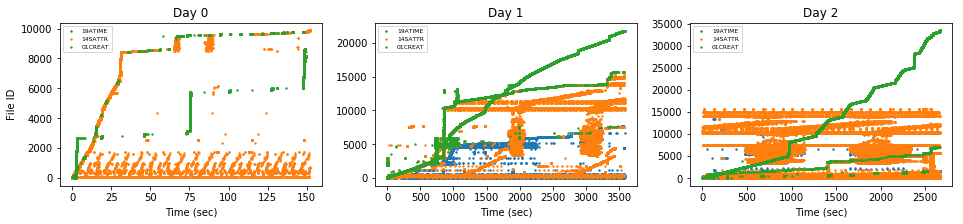

In [5]:
keyids = {}; plot_days(['19ATIME', '14SATTR',  '01CREAT'])

## deceiving data visualization
Creating the index matters and shows different locality. We need to know the spatial locality of these namespace requests.

In [113]:
change_record = [('a', 'b'),
                 ('b', 'c'),
                 ('a', 'e'),
                 ('c', 'f'),
                 ('c', 'g'),
                 ('e', 'h'),
                 ('b', 'i'),
                 ('g', 'j')]

inodes = {} # ino -> children
for parent, child in change_record:
    if parent not in inodes:
        inodes[parent] = []
    inodes[parent].append(child)

def dump_subtrees(root, inodes, level=0):
    if level == 0:
        print '  ' + root
    elif level == 1:
        print '  |_' + root        
    else:
        print level*'  ' + '|_' + root
    for child in inodes[root]:
        if child in inodes:
            dump_subtrees(child, inodes, level+1)
        else:
            print (level+1)*'  ' + '|_' + child

dump_subtrees('a', inodes)

  a
  |_b
    |_c
      |_f
      |_g
        |_j
    |_i
  |_e
    |_h


## Questions
How does Ceph do this? We can maintain a dictionary of paths because recursing down a tree is overly complicated. Can we just maintain a list of directories and directory entries? How does Ceph do a fast lookup without scanning the file system every time??

In [205]:
ops = df1[(df1['type'] == '02MKDIR') | (df1['type'] == '01CREAT')]
#ops = ops.head(20)
inodes = {} # all inodes, i.e. the namespace
proots = [] # potential roots, i.e. inodes with parents
childs = []
for _, op in ops.iterrows():
    msg    = op['msg'].split(' ')
    child  = msg[0].split('=')[1][:-1][1:]#m.split(':')[0]
    parent = msg[1].split('=')[1][:-1][1:]#.split(':')[0]
    if parent == child:
        continue
    if parent not in inodes:
        inodes[parent] = []
    inodes[parent].append(child)
    
    if parent not in proots:
        proots.append(parent)
    if child not in childs:
        childs.append(child)

roots = []
for root in proots:
    if root not in childs:
        roots.append(root)
for root in roots:
    dump_subtrees(root, inodes)
    
print roots

  0x20a3a257a:0x17598:0x0
  |_0x20a3a1f93:0x1689e:0x0
  |_0x20a3a1f93:0x168b0:0x0
  |_0x20a3a1f93:0x168c3:0x0
  |_0x20a3a1f93:0x168d1:0x0
  |_0x20a3a1f93:0x168e1:0x0
  |_0x20a3a1f93:0x168f1:0x0
  |_0x20a3a1f93:0x16901:0x0
  |_0x20a3a1f93:0x1690f:0x0
  |_0x20a3a1f93:0x1691f:0x0
  |_0x20a3a1f93:0x1692e:0x0
  |_0x20a3a1f93:0x1693e:0x0
  |_0x20a3a1f93:0x1694d:0x0
  |_0x20a3a1f93:0x1695c:0x0
  |_0x20a3a1f93:0x1696c:0x0
  |_0x20a3a1f93:0x1697c:0x0
  |_0x20a3a1f93:0x1698c:0x0
  |_0x20a3a1f93:0x1699c:0x0
  |_0x20a3a1f93:0x169a8:0x0
  |_0x20a3a1f93:0x169b8:0x0
  |_0x20a3a1f93:0x169c7:0x0
  |_0x20a3a1f93:0x169d7:0x0
  |_0x20a3a1f93:0x169e7:0x0
  |_0x20a3a1f93:0x169f7:0x0
  |_0x20a3a1f93:0x16a09:0x0
  |_0x20a3a1f93:0x16a1a:0x0
  |_0x20a3a1f93:0x16a2b:0x0
  |_0x20a3a1f93:0x16a3b:0x0
  |_0x20a3a1f93:0x16a4b:0x0
  |_0x20a3a1f93:0x16a5b:0x0
  |_0x20a3a1f93:0x16a6d:0x0
  |_0x20a3a1f93:0x16a7d:0x0
  |_0x20a3a1f93:0x16a8d:0x0
  0x20a3a257a:0x17706:0x0
  |_0x20a3a1fe9:0xca28:0x0
  |_0x20a3a1fe9:0xca37:0x

  |_0x20a3a1f87:0x16031:0x0
  |_0x20a3a1f87:0x16041:0x0
  |_0x20a3a1f87:0x1604f:0x0
  |_0x20a3a1f87:0x1605f:0x0
  |_0x20a3a1f87:0x1606f:0x0
  |_0x20a3a1f87:0x1607d:0x0
  |_0x20a3a1f87:0x1608a:0x0
  |_0x20a3a1f87:0x16099:0x0
  |_0x20a3a1f87:0x160a9:0x0
  |_0x20a3a1f87:0x160b7:0x0
  |_0x20a3a1f87:0x160c7:0x0
  |_0x20a3a1f87:0x160d6:0x0
  |_0x20a3a1f87:0x160e4:0x0
  |_0x20a3a1f87:0x160f4:0x0
  |_0x20a3a1f87:0x16100:0x0
  |_0x20a3a1f87:0x16110:0x0
  |_0x20a3a1f87:0x1611f:0x0
  0x20a3a257a:0x177f2:0x0
  |_0x20a3a284f:0x17b03:0x0
  |_0x20a3a284f:0x17b13:0x0
  |_0x20a3a284f:0x17b23:0x0
  |_0x20a3a284f:0x17b33:0x0
  |_0x20a3a284f:0x17b44:0x0
  |_0x20a3a284f:0x17b53:0x0
  |_0x20a3a284f:0x17b67:0x0
  |_0x20a3a284f:0x17b77:0x0
  |_0x20a3a284f:0x17b87:0x0
  |_0x20a3a284f:0x17b98:0x0
  |_0x20a3a284f:0x17ba8:0x0
  |_0x20a3a284f:0x17bb4:0x0
  |_0x20a3a284f:0x17bc3:0x0
  |_0x20a3a284f:0x17bd3:0x0
  |_0x20a3a284f:0x17be3:0x0
  |_0x20a3a284f:0x17bf1:0x0
  |_0x20a3a284f:0x17c03:0x0
  |_0x20a3a284f:0x17c1

  |_0x20a3a1f9a:0x17a62:0x0
  |_0x20a3a1f9a:0x17a71:0x0
  |_0x20a3a1f9a:0x17a72:0x0
  |_0x20a3a1f9a:0x17a81:0x0
  |_0x20a3a1f9a:0x17a82:0x0
  |_0x20a3a1f9a:0x17a93:0x0
  |_0x20a3a1f9a:0x17a94:0x0
  |_0x20a3a1f9a:0x17aa3:0x0
  |_0x20a3a1f9a:0x17aa4:0x0
  |_0x20a3a1f9a:0x17ab3:0x0
  |_0x20a3a1f9a:0x17ab4:0x0
  |_0x20a3a1f9a:0x17ac4:0x0
  |_0x20a3a1f9a:0x17ac5:0x0
  |_0x20a3a1f9a:0x17ad4:0x0
  |_0x20a3a1f9a:0x17ad5:0x0
  |_0x20a3a1f9a:0x17ae4:0x0
  |_0x20a3a1f9a:0x17ae5:0x0
  |_0x20a3a1f9a:0x17af7:0x0
  |_0x20a3a1f9a:0x17af8:0x0
  |_0x20a3a1f9a:0x17b06:0x0
  |_0x20a3a1f9a:0x17b07:0x0
  |_0x20a3a1f9a:0x17b16:0x0
  |_0x20a3a1f9a:0x17b17:0x0
  |_0x20a3a1f9a:0x17b27:0x0
  |_0x20a3a1f9a:0x17b28:0x0
  0x20a3a257a:0x176aa:0x0
  |_0x20a3a202b:0xceb5:0x0
  |_0x20a3a202b:0xcec3:0x0
  |_0x20a3a202b:0xced2:0x0
  |_0x20a3a202b:0xcee2:0x0
  |_0x20a3a202b:0xcef2:0x0
  |_0x20a3a202b:0xcf02:0x0
  |_0x20a3a202b:0xcf13:0x0
  |_0x20a3a202b:0xcf22:0x0
  |_0x20a3a202b:0xcf2f:0x0
  |_0x20a3a202b:0xcf3f:0x0
  |_

  |_0x20a3a284f:0x17b24:0x0
  |_0x20a3a284f:0x17b34:0x0
  |_0x20a3a284f:0x17b43:0x0
  |_0x20a3a284f:0x17b52:0x0
  |_0x20a3a284f:0x17b61:0x0
  |_0x20a3a284f:0x17b71:0x0
  |_0x20a3a284f:0x17b7f:0x0
  |_0x20a3a284f:0x17b8f:0x0
  |_0x20a3a284f:0x17b9d:0x0
  |_0x20a3a284f:0x17baf:0x0
  |_0x20a3a284f:0x17bbf:0x0
  |_0x20a3a284f:0x17bd1:0x0
  |_0x20a3a284f:0x17bdf:0x0
  |_0x20a3a284f:0x17bef:0x0
  |_0x20a3a284f:0x17bff:0x0
  |_0x20a3a284f:0x17c0d:0x0
  |_0x20a3a284f:0x17c1c:0x0
  |_0x20a3a284f:0x17c2d:0x0
  |_0x20a3a284f:0x17c40:0x0
  |_0x20a3a284f:0x17c50:0x0
  |_0x20a3a284f:0x17c62:0x0
  |_0x20a3a284f:0x17c72:0x0
  |_0x20a3a284f:0x17c84:0x0
  |_0x20a3a284f:0x17c97:0x0
  |_0x20a3a284f:0x17ca8:0x0
  |_0x20a3a284f:0x17cba:0x0
  |_0x20a3a284f:0x17cce:0x0
  |_0x20a3a284f:0x17ce1:0x0
  |_0x20a3a284f:0x17cf1:0x0
  0x20a3a257a:0x1757e:0x0
  |_0x20a3a1f9a:0x1791a:0x0
  |_0x20a3a1f9a:0x1792b:0x0
  |_0x20a3a1f9a:0x1793b:0x0
  |_0x20a3a1f9a:0x1794c:0x0
  |_0x20a3a1f9a:0x1795e:0x0
  |_0x20a3a1f9a:0x1796

  |_0x20a3a1f87:0x16028:0x0
  |_0x20a3a1f87:0x16037:0x0
  |_0x20a3a1f87:0x16045:0x0
  |_0x20a3a1f87:0x16056:0x0
  |_0x20a3a1f87:0x16066:0x0
  |_0x20a3a1f87:0x16076:0x0
  |_0x20a3a1f87:0x16085:0x0
  |_0x20a3a1f87:0x16094:0x0
  |_0x20a3a1f87:0x160a5:0x0
  |_0x20a3a1f87:0x160b5:0x0
  |_0x20a3a1f87:0x160c3:0x0
  |_0x20a3a1f87:0x160d2:0x0
  |_0x20a3a1f87:0x160e1:0x0
  |_0x20a3a1f87:0x160ef:0x0
  |_0x20a3a1f87:0x160ff:0x0
  |_0x20a3a1f87:0x1610f:0x0
  |_0x20a3a1f87:0x1611e:0x0
  0x20a3a257a:0x17764:0x0
  |_0x20a3a1ff0:0x1ea2a:0x0
  |_0x20a3a1ff0:0x1ea3b:0x0
  |_0x20a3a1ff0:0x1ea4b:0x0
  |_0x20a3a1ff0:0x1ea5a:0x0
  |_0x20a3a1ff0:0x1ea6b:0x0
  |_0x20a3a1ff0:0x1ea7f:0x0
  |_0x20a3a1ff0:0x1ea91:0x0
  |_0x20a3a1ff0:0x1eaa4:0x0
  |_0x20a3a1ff0:0x1eab5:0x0
  |_0x20a3a1ff0:0x1eac6:0x0
  |_0x20a3a1ff0:0x1ead6:0x0
  |_0x20a3a1ff0:0x1eae7:0x0
  |_0x20a3a1ff0:0x1eaf8:0x0
  |_0x20a3a1ff0:0x1eb0c:0x0
  |_0x20a3a1ff0:0x1eb1e:0x0
  |_0x20a3a1ff0:0x1eb2f:0x0
  |_0x20a3a1ff0:0x1eb3f:0x0
  |_0x20a3a1ff0:0x1eb5

  |_0x20a3a2012:0xe778:0x0
  |_0x20a3a2012:0xe787:0x0
  |_0x20a3a2012:0xe796:0x0
  |_0x20a3a2012:0xe7a3:0x0
  |_0x20a3a2012:0xe7b2:0x0
  |_0x20a3a2012:0xe7c2:0x0
  |_0x20a3a2012:0xe7d2:0x0
  |_0x20a3a2012:0xe7e1:0x0
  |_0x20a3a2012:0xe7f1:0x0
  |_0x20a3a2012:0xe7fe:0x0
  |_0x20a3a2012:0xe80c:0x0
  |_0x20a3a2012:0xe81b:0x0
  |_0x20a3a2012:0xe82b:0x0
  |_0x20a3a2012:0xe839:0x0
  |_0x20a3a2012:0xe848:0x0
  |_0x20a3a2012:0xe857:0x0
  |_0x20a3a2012:0xe866:0x0
  |_0x20a3a2012:0xe875:0x0
  |_0x20a3a2012:0xe885:0x0
  |_0x20a3a2012:0xe894:0x0
  |_0x20a3a2012:0xe8a3:0x0
  |_0x20a3a2012:0xe8b3:0x0
  |_0x20a3a2012:0xe8c2:0x0
  0x20a3a257a:0x177e2:0x0
  |_0x20a3a284f:0x17b0e:0x0
  |_0x20a3a284f:0x17b1d:0x0
  |_0x20a3a284f:0x17b2a:0x0
  |_0x20a3a284f:0x17b39:0x0
  |_0x20a3a284f:0x17b4a:0x0
  |_0x20a3a284f:0x17b5a:0x0
  |_0x20a3a284f:0x17b68:0x0
  |_0x20a3a284f:0x17b75:0x0
  |_0x20a3a284f:0x17b85:0x0
  |_0x20a3a284f:0x17b93:0x0
  |_0x20a3a284f:0x17ba0:0x0
  |_0x20a3a284f:0x17bb0:0x0
  |_0x20a3a284f:0

  |_0x20a3a1f9a:0x17aa5:0x0
  |_0x20a3a1f9a:0x17ab5:0x0
  |_0x20a3a1f9a:0x17ac8:0x0
  |_0x20a3a1f9a:0x17adb:0x0
  |_0x20a3a1f9a:0x17aeb:0x0
  |_0x20a3a1f9a:0x17afc:0x0
  |_0x20a3a1f9a:0x17b0d:0x0
  |_0x20a3a1f9a:0x17b1f:0x0
  0x20a3a257a:0x17638:0x0
  |_0x20a3a1f87:0x15f3c:0x0
  |_0x20a3a1f87:0x15f4c:0x0
  |_0x20a3a1f87:0x15f5a:0x0
  |_0x20a3a1f87:0x15f69:0x0
  |_0x20a3a1f87:0x15f75:0x0
  |_0x20a3a1f87:0x15f83:0x0
  |_0x20a3a1f87:0x15f93:0x0
  |_0x20a3a1f87:0x15fa2:0x0
  |_0x20a3a1f87:0x15fb1:0x0
  |_0x20a3a1f87:0x15fbf:0x0
  |_0x20a3a1f87:0x15fcd:0x0
  |_0x20a3a1f87:0x15fdc:0x0
  |_0x20a3a1f87:0x15fe9:0x0
  |_0x20a3a1f87:0x15ff6:0x0
  |_0x20a3a1f87:0x16003:0x0
  |_0x20a3a1f87:0x16012:0x0
  |_0x20a3a1f87:0x16020:0x0
  |_0x20a3a1f87:0x1602f:0x0
  |_0x20a3a1f87:0x1603f:0x0
  |_0x20a3a1f87:0x1604c:0x0
  |_0x20a3a1f87:0x1605c:0x0
  |_0x20a3a1f87:0x16068:0x0
  |_0x20a3a1f87:0x16077:0x0
  |_0x20a3a1f87:0x16087:0x0
  |_0x20a3a1f87:0x16095:0x0
  |_0x20a3a1f87:0x160a6:0x0
  |_0x20a3a1f87:0x160b

  |_0x20a3a320f:0xaf29:0x0
  |_0x20a3a320f:0xaf2a:0x0
  |_0x20a3a320f:0xaf2b:0x0
  |_0x20a3a320f:0xaf2c:0x0
  |_0x20a3a320f:0xaf2d:0x0
  |_0x20a3a320f:0xaf2e:0x0
  |_0x20a3a320f:0xaf2f:0x0
  |_0x20a3a320f:0xaf30:0x0
  |_0x20a3a320f:0xaf31:0x0
  |_0x20a3a320f:0xaf32:0x0
  |_0x20a3a320f:0xaf33:0x0
  |_0x20a3a320f:0xaf34:0x0
  |_0x20a3a320f:0xaf35:0x0
  |_0x20a3a320f:0xaf36:0x0
  |_0x20a3a320f:0xaf37:0x0
  |_0x20a3a320f:0xaf38:0x0
  |_0x20a3a320f:0xaf39:0x0
  |_0x20a3a320f:0xaf3a:0x0
  |_0x20a3a320f:0xaf3b:0x0
  |_0x20a3a320f:0xaf3c:0x0
  |_0x20a3a320f:0xaf3d:0x0
  |_0x20a3a320f:0xaf3e:0x0
  |_0x20a3a320f:0xaf3f:0x0
  |_0x20a3a320f:0xaf40:0x0
  |_0x20a3a320f:0xaf41:0x0
  |_0x20a3a320f:0xaf42:0x0
  |_0x20a3a320f:0xaf43:0x0
  |_0x20a3a320f:0xaf44:0x0
  |_0x20a3a320f:0xaf45:0x0
  |_0x20a3a320f:0xaf46:0x0
  |_0x20a3a320f:0xaf47:0x0
  |_0x20a3a320f:0xaf48:0x0
  |_0x20a3a320f:0xaf49:0x0
  |_0x20a3a320f:0xaf4a:0x0
  |_0x20a3a320f:0xaf4b:0x0
  |_0x20a3a320f:0xaf4c:0x0
  |_0x20a3a320f:0xaf4d:0x0
 

            |_0x20a3a0eed:0x155bd:0x0
            |_0x20a3a0eed:0x155c4:0x0
          |_0x20a3a0eed:0x149ca:0x0
            |_0x20a3a0eed:0x149cb:0x0
            |_0x20a3a0eed:0x149cc:0x0
            |_0x20a3a0eed:0x149cd:0x0
            |_0x20a3a0eed:0x149ce:0x0
            |_0x20a3a0eed:0x149cf:0x0
            |_0x20a3a0eed:0x149d0:0x0
            |_0x20a3a0eed:0x152eb:0x0
            |_0x20a3a0eed:0x155c6:0x0
            |_0x20a3a0eed:0x155c8:0x0
            |_0x20a3a0eed:0x155c9:0x0
            |_0x20a3a0eed:0x155cf:0x0
          |_0x20a3a0eed:0x149d1:0x0
            |_0x20a3a0eed:0x149d2:0x0
            |_0x20a3a0eed:0x149d3:0x0
            |_0x20a3a0eed:0x149d4:0x0
            |_0x20a3a0eed:0x149d5:0x0
            |_0x20a3a0eed:0x149d6:0x0
            |_0x20a3a0eed:0x149d7:0x0
            |_0x20a3a0eed:0x152ec:0x0
            |_0x20a3a0eed:0x155c5:0x0
            |_0x20a3a0eed:0x155c7:0x0
            |_0x20a3a0eed:0x155ca:0x0
            |_0x20a3a0eed:0x155d3:0x0
          |_0x20

            |_0x20a3a0eed:0x14dc3:0x0
            |_0x20a3a0eed:0x1531c:0x0
            |_0x20a3a0eed:0x15b6f:0x0
            |_0x20a3a0eed:0x15b72:0x0
            |_0x20a3a0eed:0x15b74:0x0
            |_0x20a3a0eed:0x15b7f:0x0
          |_0x20a3a0eed:0x14dc5:0x0
          |_0x20a3a0eed:0x153d2:0x0
        |_0x20a3a0eed:0x14dc4:0x0
        |_0x20a3a0eed:0x14dc6:0x0
        |_0x20a3a0eed:0x14dc7:0x0
        |_0x20a3a0eed:0x15427:0x0
        |_0x20a3a0eed:0x1542b:0x0
        |_0x20a3a0eed:0x1542c:0x0
        |_0x20a3a0eed:0x15434:0x0
        |_0x20a3a0eed:0x15439:0x0
        |_0x20a3a0eed:0x15b64:0x0
        |_0x20a3a0eed:0x15b85:0x0
        |_0x20a3a0eed:0x15b86:0x0
        |_0x20a3a0eed:0x15b88:0x0
        |_0x20a3a0eed:0x15b89:0x0
        |_0x20a3a0eed:0x15b8a:0x0
        |_0x20a3a0eed:0x15b8b:0x0
        |_0x20a3a0eed:0x15b8c:0x0
        |_0x20a3a0eed:0x161d3:0x0
        |_0x20a3a0eed:0x1623a:0x0
          |_0x20a3a0eed:0x1623b:0x0
            |_0x20a3a0eed:0x16246:0x0
          |_0x

          |_0x20a3a0eed:0x1688f:0x0
          |_0x20a3a0eed:0x16bab:0x0
          |_0x20a3a0eed:0x16bbb:0x0
          |_0x20a3a0eed:0x16be1:0x0
          |_0x20a3a0eed:0x16be6:0x0
          |_0x20a3a0eed:0x16bf3:0x0
          |_0x20a3a0eed:0x16bf4:0x0
        |_0x20a3a0eed:0x1477e:0x0
          |_0x20a3a0eed:0x1477f:0x0
            |_0x20a3a0eed:0x14e45:0x0
              |_0x20a3a0eed:0x14e46:0x0
              |_0x20a3a0eed:0x14e47:0x0
              |_0x20a3a0eed:0x14e48:0x0
              |_0x20a3a0eed:0x15306:0x0
              |_0x20a3a0eed:0x1543c:0x0
              |_0x20a3a0eed:0x1543e:0x0
            |_0x20a3a0eed:0x14e4a:0x0
            |_0x20a3a0eed:0x153df:0x0
          |_0x20a3a0eed:0x14780:0x0
          |_0x20a3a0eed:0x14781:0x0
          |_0x20a3a0eed:0x14782:0x0
          |_0x20a3a0eed:0x14783:0x0
          |_0x20a3a0eed:0x14784:0x0
          |_0x20a3a0eed:0x14785:0x0
          |_0x20a3a0eed:0x14786:0x0
          |_0x20a3a0eed:0x14787:0x0
          |_0x20a3a0eed:0x14e49:0x0


            |_0x20a3a0eed:0x151ea:0x0
            |_0x20a3a0eed:0x151eb:0x0
            |_0x20a3a0eed:0x151ec:0x0
            |_0x20a3a0eed:0x153ac:0x0
            |_0x20a3a0eed:0x15ae4:0x0
            |_0x20a3a0eed:0x15ae5:0x0
            |_0x20a3a0eed:0x15aee:0x0
            |_0x20a3a0eed:0x15b04:0x0
          |_0x20a3a0eed:0x151ed:0x0
            |_0x20a3a0eed:0x151ee:0x0
            |_0x20a3a0eed:0x151ef:0x0
            |_0x20a3a0eed:0x151f0:0x0
            |_0x20a3a0eed:0x151f1:0x0
            |_0x20a3a0eed:0x151f2:0x0
            |_0x20a3a0eed:0x151f3:0x0
            |_0x20a3a0eed:0x153ad:0x0
            |_0x20a3a0eed:0x15ae6:0x0
            |_0x20a3a0eed:0x15ae7:0x0
            |_0x20a3a0eed:0x15aef:0x0
            |_0x20a3a0eed:0x15b05:0x0
          |_0x20a3a0eed:0x151f4:0x0
            |_0x20a3a0eed:0x151f5:0x0
            |_0x20a3a0eed:0x151f6:0x0
            |_0x20a3a0eed:0x151f7:0x0
            |_0x20a3a0eed:0x151f8:0x0
            |_0x20a3a0eed:0x151f9:0x0
            |_0x

      |_0x20a3a1234:0x1d83:0x0
      |_0x20a3a1234:0x1d84:0x0
      |_0x20a3a1234:0x1d85:0x0
      |_0x20a3a1234:0x1d86:0x0
        |_0x20a3a1234:0x1d87:0x0
        |_0x20a3a1234:0x1d88:0x0
        |_0x20a3a1234:0x1d89:0x0
      |_0x20a3a1234:0x1d8a:0x0
      |_0x20a3a1234:0x1d8b:0x0
      |_0x20a3a1234:0x1d8c:0x0
      |_0x20a3a1234:0x1d8d:0x0
      |_0x20a3a1234:0x1d8e:0x0
      |_0x20a3a1234:0x1d8f:0x0
      |_0x20a3a1234:0x1d90:0x0
      |_0x20a3a1234:0x1d91:0x0
      |_0x20a3a1234:0x1d92:0x0
      |_0x20a3a1234:0x1d93:0x0
      |_0x20a3a1234:0x1d94:0x0
      |_0x20a3a1234:0x1d95:0x0
      |_0x20a3a1234:0x1d96:0x0
      |_0x20a3a1234:0x1d97:0x0
      |_0x20a3a1234:0x1d98:0x0
      |_0x20a3a1234:0x1d99:0x0
      |_0x20a3a1234:0x1d9a:0x0
      |_0x20a3a1234:0x1d9b:0x0
      |_0x20a3a1234:0x1d9c:0x0
      |_0x20a3a1234:0x1d9d:0x0
    |_0x20a3a1234:0x1d9e:0x0
      |_0x20a3a1234:0x1da9:0x0
      |_0x20a3a1234:0x1daa:0x0
      |_0x20a3a1234:0x1dab:0x0
    |_0x20a3a1234:0x1d9f:0x0
      

      |_0x20a3a123d:0x3d94:0x0
      |_0x20a3a123d:0x3d95:0x0
      |_0x20a3a123d:0x3d96:0x0
      |_0x20a3a123d:0x3d97:0x0
      |_0x20a3a123d:0x3d98:0x0
      |_0x20a3a123d:0x3d99:0x0
      |_0x20a3a123d:0x3d9a:0x0
      |_0x20a3a123d:0x3d9b:0x0
      |_0x20a3a123d:0x3d9c:0x0
      |_0x20a3a123d:0x3d9d:0x0
      |_0x20a3a123d:0x3d9e:0x0
    |_0x20a3a123d:0x3d9f:0x0
      |_0x20a3a123d:0x3daa:0x0
      |_0x20a3a123d:0x3dab:0x0
      |_0x20a3a123d:0x3dac:0x0
      |_0x20a3a123d:0x3dae:0x0
      |_0x20a3a123d:0x3db0:0x0
      |_0x20a3a123d:0x3db2:0x0
      |_0x20a3a123d:0x3db4:0x0
      |_0x20a3a123d:0x3db6:0x0
      |_0x20a3a123d:0x3db8:0x0
      |_0x20a3a123d:0x3dba:0x0
      |_0x20a3a123d:0x3dbc:0x0
      |_0x20a3a123d:0x3dbe:0x0
      |_0x20a3a123d:0x3dc0:0x0
      |_0x20a3a123d:0x3dc2:0x0
      |_0x20a3a123d:0x3dc4:0x0
      |_0x20a3a123d:0x3dc6:0x0
      |_0x20a3a123d:0x3dc8:0x0
      |_0x20a3a123d:0x3dca:0x0
      |_0x20a3a123d:0x3dcc:0x0
      |_0x20a3a123d:0x3dce:0x0
      |_0x

      |_0x20a3a1252:0x29c4:0x0
      |_0x20a3a1252:0x29c5:0x0
      |_0x20a3a1252:0x29c6:0x0
    |_0x20a3a1252:0x29c7:0x0
      |_0x20a3a1252:0x29d2:0x0
      |_0x20a3a1252:0x29d3:0x0
      |_0x20a3a1252:0x29d4:0x0
      |_0x20a3a1252:0x29d6:0x0
      |_0x20a3a1252:0x29d8:0x0
      |_0x20a3a1252:0x29da:0x0
      |_0x20a3a1252:0x29dc:0x0
      |_0x20a3a1252:0x29de:0x0
      |_0x20a3a1252:0x29e0:0x0
      |_0x20a3a1252:0x29e2:0x0
      |_0x20a3a1252:0x29e4:0x0
      |_0x20a3a1252:0x29e6:0x0
      |_0x20a3a1252:0x29e8:0x0
      |_0x20a3a1252:0x29ea:0x0
      |_0x20a3a1252:0x29ec:0x0
      |_0x20a3a1252:0x29ee:0x0
      |_0x20a3a1252:0x29f0:0x0
      |_0x20a3a1252:0x29f2:0x0
      |_0x20a3a1252:0x29f4:0x0
      |_0x20a3a1252:0x29f6:0x0
      |_0x20a3a1252:0x29f8:0x0
      |_0x20a3a1252:0x29fa:0x0
    |_0x20a3a1252:0x29c8:0x0
      |_0x20a3a1252:0x29d0:0x0
      |_0x20a3a1252:0x29d1:0x0
    |_0x20a3a1252:0x29c9:0x0
    |_0x20a3a1252:0x29cb:0x0
    |_0x20a3a1252:0x29cc:0x0
    |_0x20a3a1252:

  |_0x20a3a25b6:0x179f9:0x0
  |_0x20a3a3340:0xf62:0x0
  |_0x20a3a2773:0x1867e:0x0
  |_0x20a3a3340:0xf63:0x0
  |_0x20a3a3340:0xf64:0x0
  |_0x20a3a2773:0x1867f:0x0
  |_0x20a3a25b6:0x179fb:0x0
  |_0x20a3a3340:0xf65:0x0
  |_0x20a3a25b6:0x179fc:0x0
  |_0x20a3a3340:0xf66:0x0
  |_0x20a3a25b6:0x179fd:0x0
  |_0x20a3a25b6:0x179fe:0x0
  |_0x20a3a2773:0x18681:0x0
  |_0x20a3a25b6:0x179ff:0x0
  |_0x20a3a3340:0xf67:0x0
  |_0x20a3a2773:0x18682:0x0
  |_0x20a3a25b6:0x17a00:0x0
  |_0x20a3a25b6:0x17a01:0x0
  |_0x20a3a3340:0xf69:0x0
  |_0x20a3a25b6:0x17a06:0x0
  |_0x20a3a25b6:0x17a08:0x0
  |_0x20a3a25b6:0x17a09:0x0
  |_0x20a3a3340:0xf72:0x0
  |_0x20a3a3340:0xf73:0x0
  |_0x20a3a2773:0x1868b:0x0
  |_0x20a3a2773:0x1868d:0x0
  |_0x20a3a3340:0xf76:0x0
  |_0x20a3a2773:0x1868e:0x0
  |_0x20a3a3340:0xf77:0x0
  |_0x20a3a2773:0x1868f:0x0
  |_0x20a3a2773:0x18690:0x0
  |_0x20a3a2769:0x1cd56:0x0
  |_0x20a3a2773:0x18ad5:0x0
  |_0x20a3a25b6:0x17e04:0x0
  |_0x20a3a3340:0x136d:0x0
  |_0x20a3a2769:0x1cd57:0x0
  |_0x20a3a25b6

    |_0x20a3a3342:0x118fc:0x0
    |_0x20a3a3342:0x118fd:0x0
    |_0x20a3a3342:0x118fe:0x0
    |_0x20a3a3342:0x118ff:0x0
    |_0x20a3a3342:0x11900:0x0
    |_0x20a3a3342:0x11901:0x0
    |_0x20a3a3342:0x11902:0x0
    |_0x20a3a3342:0x11903:0x0
    |_0x20a3a3342:0x11904:0x0
    |_0x20a3a3342:0x11905:0x0
    |_0x20a3a3342:0x11906:0x0
    |_0x20a3a3342:0x11908:0x0
  |_0x20a3a3342:0x1190a:0x0
  |_0x20a3a3342:0x1190b:0x0
  |_0x20a3a3342:0x119b0:0x0
    |_0x20a3a3342:0x119b1:0x0
    |_0x20a3a3342:0x119b2:0x0
    |_0x20a3a3342:0x119b3:0x0
    |_0x20a3a3342:0x119b4:0x0
    |_0x20a3a3342:0x119b5:0x0
    |_0x20a3a3342:0x119b6:0x0
    |_0x20a3a3342:0x119b7:0x0
    |_0x20a3a3342:0x119b8:0x0
    |_0x20a3a3342:0x119b9:0x0
    |_0x20a3a3342:0x119ba:0x0
    |_0x20a3a3342:0x119bb:0x0
    |_0x20a3a3342:0x119bd:0x0
  |_0x20a3a3342:0x119c0:0x0
  |_0x20a3a3342:0x119c1:0x0
  |_0x20a3a3342:0x11a4f:0x0
    |_0x20a3a3342:0x11a50:0x0
    |_0x20a3a3342:0x11a51:0x0
    |_0x20a3a3342:0x11a52:0x0
    |_0x20a3a3342:0x11